# install

```
sudo add-apt-repository ppa:openscad/releases
sudo apt-get update
sudo apt-get install openscad

pip install solidpython2 jupyterscad matplotlib hilbertcurve
```

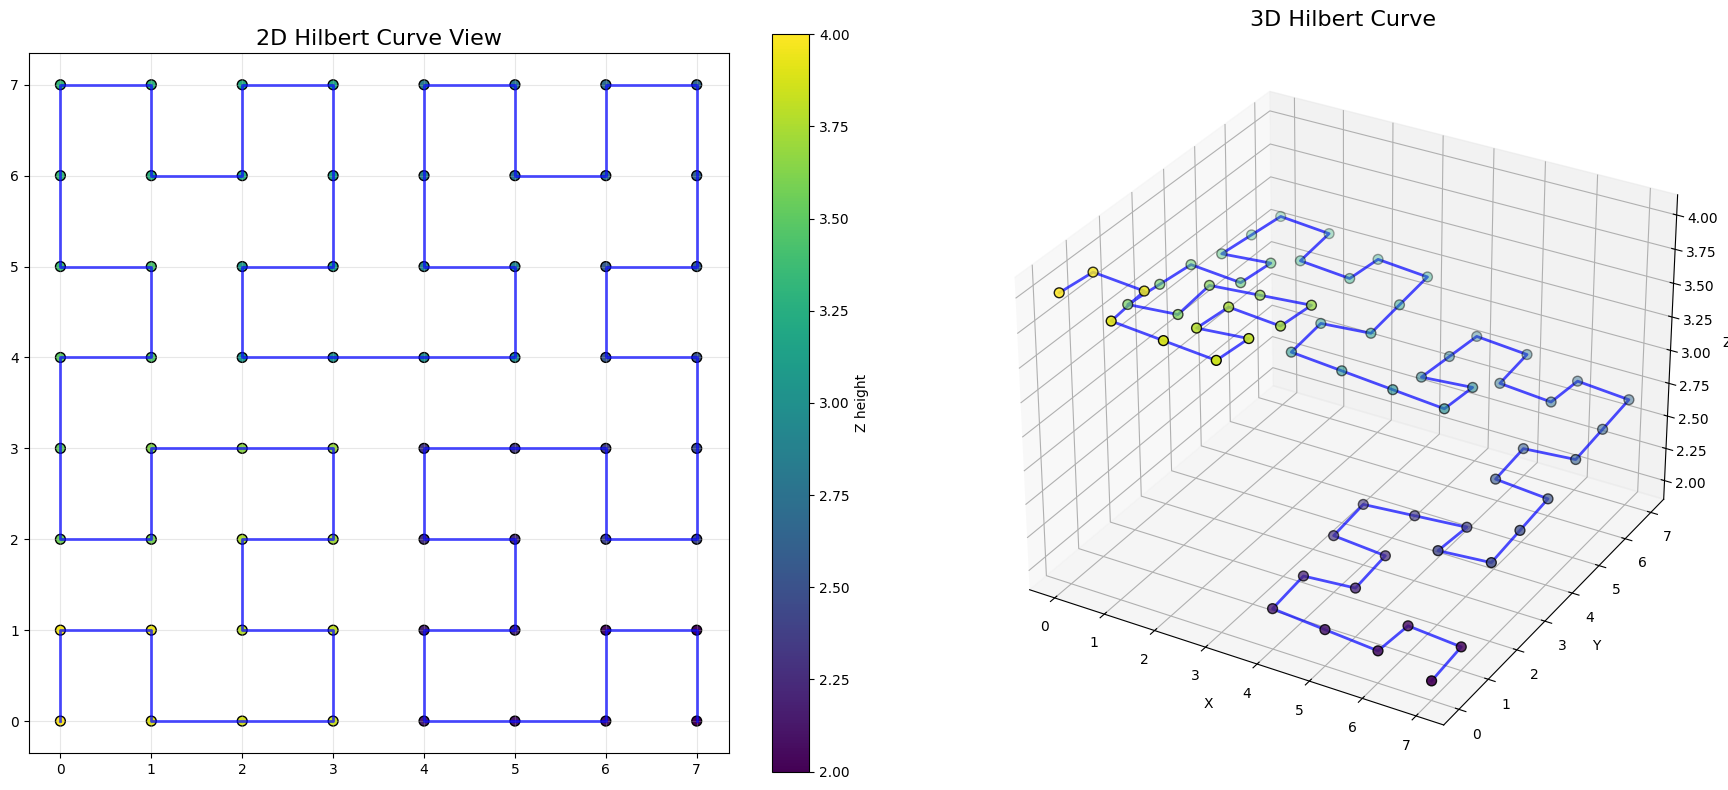

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from hilbertcurve.hilbertcurve import HilbertCurve

def get_hilbert_3d_curve(order, spacing=1.0, z_size=1.0, z_offset=0.0):
    dimensions = 2
    hilbert_curve = HilbertCurve(order, dimensions)
    distances_along_curve = list(range(2 ** (dimensions * order)))
    points = hilbert_curve.points_from_distances(distances_along_curve)

    points *= spacing
    
    # Generate z coordinates with size and offset
    z_coords = np.linspace(z_size + z_offset, z_offset, len(points))
    
    # Create a single numpy array of shape (n, 3)
    return np.column_stack((points, z_coords))

points = get_hilbert_3d_curve(3, 1, 2, 2)
    

def plot_hilbert_curve(points, connect_points=True, show_points=True):
    """
    Plot a Hilbert curve from the given points in both 2D and 3D.
    
    Args:
        points (ndarray): Nx3 array of points (x, y, z)
        connect_points (bool): Whether to connect points with lines
        show_points (bool): Whether to display the individual points
    """
    # Extract coordinates from the points array
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    z_coords = points[:, 2]
    
    # Create a figure with two subplots (2D and 3D)
    fig = plt.figure(figsize=(18, 8))
    
    # 2D plot
    ax1 = fig.add_subplot(121)
    
    # Plot the curve (connected points) in 2D
    if connect_points:
        ax1.plot(x_coords, y_coords, '-', linewidth=2, color='blue', alpha=0.7)
    
    # Plot the individual points in 2D
    if show_points:
        scatter = ax1.scatter(x_coords, y_coords, s=50, c=z_coords, cmap='viridis', edgecolors='black')
    
    # Customize the 2D plot
    ax1.set_title('2D Hilbert Curve View', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    fig.colorbar(scatter, ax=ax1, label='Z height')
    
    # 3D plot
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot the curve (connected points) in 3D
    if connect_points:
        ax2.plot(x_coords, y_coords, z_coords, '-', linewidth=2, color='blue', alpha=0.7)
    
    # Plot the individual points in 3D
    if show_points:
        ax2.scatter(x_coords, y_coords, z_coords, s=50, c=z_coords, cmap='viridis', edgecolors='black')
    
    # Customize the 3D plot
    ax2.set_title('3D Hilbert Curve', fontsize=16)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
plot_hilbert_curve(points)
